In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [74]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-05 00:19:42,836 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 00:19:42,839 INFO: Initializing external client
2025-03-05 00:19:42,840 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 00:19:43,682 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214704


In [75]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1214704/featurestores/1202338/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [76]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


In [77]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [78]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2025-02-03 21:00:00+00:00,2,0
1,2025-02-03 22:00:00+00:00,2,0
2,2025-02-03 23:00:00+00:00,2,0
3,2025-02-04 00:00:00+00:00,2,0
4,2025-02-04 01:00:00+00:00,2,0


In [79]:
ts_data["pickup_hour"].min()

'2025-02-03 21:00:00+00:00'

In [80]:
ts_data["pickup_hour"].max()

'2025-03-04 22:00:00+00:00'

In [81]:
ts_data_copy = ts_data.copy()

In [82]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [83]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175198 entries, 0 to 175197
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   pickup_hour         175198 non-null  datetime64[ns, UTC]
 1   pickup_location_id  175198 non-null  int32              
 2   rides               175198 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 2.7 MB


In [84]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [85]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175198 entries, 0 to 175197
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         175198 non-null  datetime64[ns]
 1   pickup_location_id  175198 non-null  int32         
 2   rides               175198 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 2.7 MB


In [86]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [87]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2025-02-03 21:00:00,2,0,2025-02
1,2025-02-03 22:00:00,2,0,2025-02
2,2025-02-03 23:00:00,2,0,2025-02
3,2025-02-04 00:00:00,2,0,2025-02
4,2025-02-04 01:00:00,2,0,2025-02
...,...,...,...,...
175193,2025-03-04 18:00:00,263,132,2025-03
175194,2025-03-04 19:00:00,263,99,2025-03
175195,2025-03-04 20:00:00,263,86,2025-03
175196,2025-03-04 21:00:00,263,76,2025-03


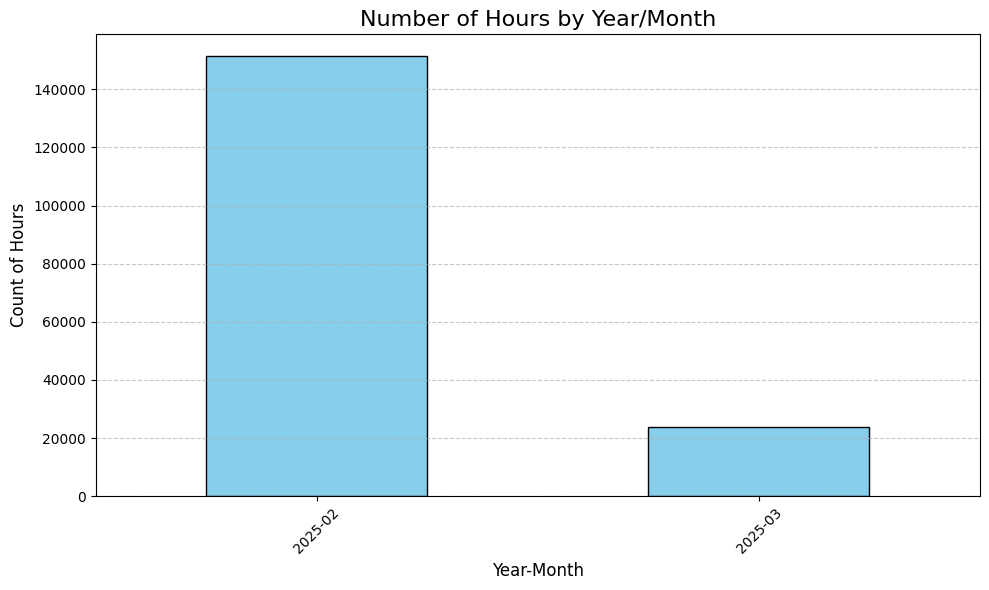

In [88]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [89]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2025-02-03 21:00:00,2,0,2025-02
1,2025-02-03 22:00:00,2,0,2025-02
2,2025-02-03 23:00:00,2,0,2025-02
3,2025-02-04 00:00:00,2,0,2025-02
4,2025-02-04 01:00:00,2,0,2025-02


In [90]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [91]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [92]:
filtered_data.shape

(0, 3)

In [93]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175198 entries, 0 to 175197
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         175198 non-null  datetime64[ns]
 1   pickup_location_id  175198 non-null  int32         
 2   rides               175198 non-null  int32         
 3   year_month          175198 non-null  period[M]     
dtypes: datetime64[ns](1), int32(2), period[M](1)
memory usage: 4.0 MB


In [94]:
ts_data.head()["pickup_hour"].values

array(['2025-02-03T21:00:00.000000000', '2025-02-03T22:00:00.000000000',
       '2025-02-03T23:00:00.000000000', '2025-02-04T00:00:00.000000000',
       '2025-02-04T01:00:00.000000000'], dtype='datetime64[ns]')

In [95]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [96]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-03 21:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-04 20:00:00,2
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,2025-03-03 21:00:00,3
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,1,2025-03-04 20:00:00,3
4,3,6,2,3,6,2,0,1,1,2,...,2,2,3,0,1,1,0,0,2025-03-03 21:00:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,24,38,18,9,6,4,0,1,0,1,...,28,27,36,26,28,58,46,34,2025-03-04 20:00:00,261
498,22,4,6,1,3,1,1,3,19,63,...,71,82,97,87,82,103,65,37,2025-03-03 21:00:00,262
499,45,21,18,6,2,1,0,5,6,13,...,96,89,104,140,111,101,87,48,2025-03-04 20:00:00,262
500,72,41,17,12,5,4,5,7,21,46,...,102,119,119,89,114,116,102,87,2025-03-03 21:00:00,263


In [97]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-03 21:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2025-03-04 20:00:00,2


In [98]:
features_copy = features.copy()

In [99]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(502, 675)

In [100]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-05 00:19:56.316294')

In [101]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(0, 674)
(0,)
(502, 674)
(502,)


In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 132.0 bytes


In [103]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [104]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23767
[LightGBM] [Info] Number of data points in the train set: 502, number of used features: 675
[LightGBM] [Info] Start training from score 22.258964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x000001EF03A73380>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [105]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [106]:
predictions

array([-5.90251637e-03, -2.10053112e-02, -7.18279238e-03,  3.44647198e-03,
        1.62781837e+00,  4.50379136e+00,  2.54667768e-02, -1.72419522e-02,
        9.99402511e-01,  1.22151470e-01, -8.63286255e-04, -1.45251460e-02,
        2.83417559e-02,  3.62618435e-03,  2.04523007e+00,  6.78618758e-02,
       -9.61226407e-03, -1.56895502e-02,  1.04730002e+00,  1.43195670e-01,
        2.22891786e+01,  3.62987897e+01,  6.98564515e-02,  8.63515906e-02,
        4.16984638e-03, -1.28618188e-03,  1.71224477e-02,  4.37551153e-02,
        5.60676034e-02,  1.11019056e-01,  1.68898440e-02, -1.95300686e-02,
        3.82941290e-03, -1.41251279e-02,  6.52098735e-02,  3.97195590e-02,
       -1.93732371e-02, -8.58840333e-03,  4.72012031e-03,  1.88476003e-03,
       -1.61906585e-02,  6.87660905e-02,  5.18511496e+00,  9.36969157e+00,
        2.02347941e+00,  2.90722181e+00, -4.00886183e-02, -1.10495852e-04,
        7.59358948e-02,  5.47040042e-03,  4.65441706e-02,  1.39847166e-02,
       -2.46096130e-02,  

In [107]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.2503


In [108]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\ranje\\Jupyter Notebooks\\Sem 2\\CDA ML\\sp25_taxi-main\\models\\lgb_model.pkl']

In [109]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [110]:
# Instantiate the model registry
model_registry = project.get_model_registry()

# Create a model in the model registry without the unsupported 'include_files' argument
model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema
)

# Save the model to a path within your Hopsworks project or local directory
model.save('C:\\Users\\ranje\\Jupyter Notebooks\\Sem 2\\CDA ML\\sp25_taxi-main\\models\\lgb_model.pkl')

# Optionally, print the URL to access the model in Hopsworks
print("Model saved successfully. Access it at:", model.get_url())


Uploading: 100.000%|██████████| 223917/223917 elapsed<00:02 remaining<00:00  1.58s/it]
Uploading: 100.000%|██████████| 2050/2050 elapsed<00:03 remaining<00:000:09,  2.32s/it]
Uploading: 100.000%|██████████| 51418/51418 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214704/models/taxi_demand_predictor_next_hour/20
Model saved successfully. Access it at: https://c.app.hopsworks.ai:443/p/1214704/models/taxi_demand_predictor_next_hour/20


In [111]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-05 00:20:14,326 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-05 00:20:14,330 INFO: Initializing external client
2025-03-05 00:20:14,330 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 00:20:15,205 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214704


In [112]:
from src.inference import get_model_predictions

In [113]:
preds = get_model_predictions(model, features_copy)

In [114]:
model.get_m

AttributeError: 'Pipeline' object has no attribute 'get_m'

In [115]:
preds

,pickup_location_id,predicted_demand
0,2,-0.0
1,2,-0.0
2,3,-0.0
3,3,0.0
4,4,2.0
...,...,...
497,261,25.0
498,262,16.0
499,262,30.0
500,263,74.0


In [116]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.2112
